In [ ]:
from data.ARCADE.dataloader import ARCADEDataset
from torch.utils.data import DataLoader
pathJson = 'data/ARCADE/processed/dataset.json'
dataset = ARCADEDataset(json_path=pathJson, split='train', task='Unsupervised')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for images in dataloader:
    print(f"Batch shape: {images.shape}")
    break


Batch shape: torch.Size([1, 1, 256, 256])


In [ ]:
from zoo.backbones import sanityCheck
sanityCheck()

ImportError: cannot import name 'sanityCheck' from 'zoo.backbones' (d:\Collateral Coronary Vessels XAI\zoo\backbones.py)

In [6]:
from zoo.models import SegmentatorCoronare
from zoo.backbones import get_backbone
model = SegmentatorCoronare(backbone='swinv2_tiny_window16_256', pretrained=False, in_channels=1)
import torch

print("SWIN")
model = SegmentatorCoronare(backbone='swinv2_tiny_window16_256', pretrained=False, in_channels=1)
dummy = torch.randn(2, 1, 256, 256)
out = model(dummy)
print(out.shape)
    
    
print('ConvNext')
model = SegmentatorCoronare(backbone='convnext_tiny', pretrained=False, in_channels=1)
dummy = torch.randn(2, 1, 256, 256)
out = model(dummy)
print(out.shape)
    
print('ViT')
model = SegmentatorCoronare(backbone='vit_small_patch16_224', pretrained=False, in_channels=1)
dummy = torch.randn(2, 1, 256, 256)
out = model(dummy)
print(out.shape)

ModuleNotFoundError: No module named 'backbones'

C:\Users\alexb\AppData\Local\Temp\ipykernel_8088\3018458235.py:25: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  mask_roi = morphology.binary_erosion(mask_roi, morphology.disk(15))
C:\Users\alexb\AppData\Local\Temp\ipykernel_8088\3018458235.py:86: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  prev_dilated = morphology.binary_dilation(accumulated_mask, disk(4))


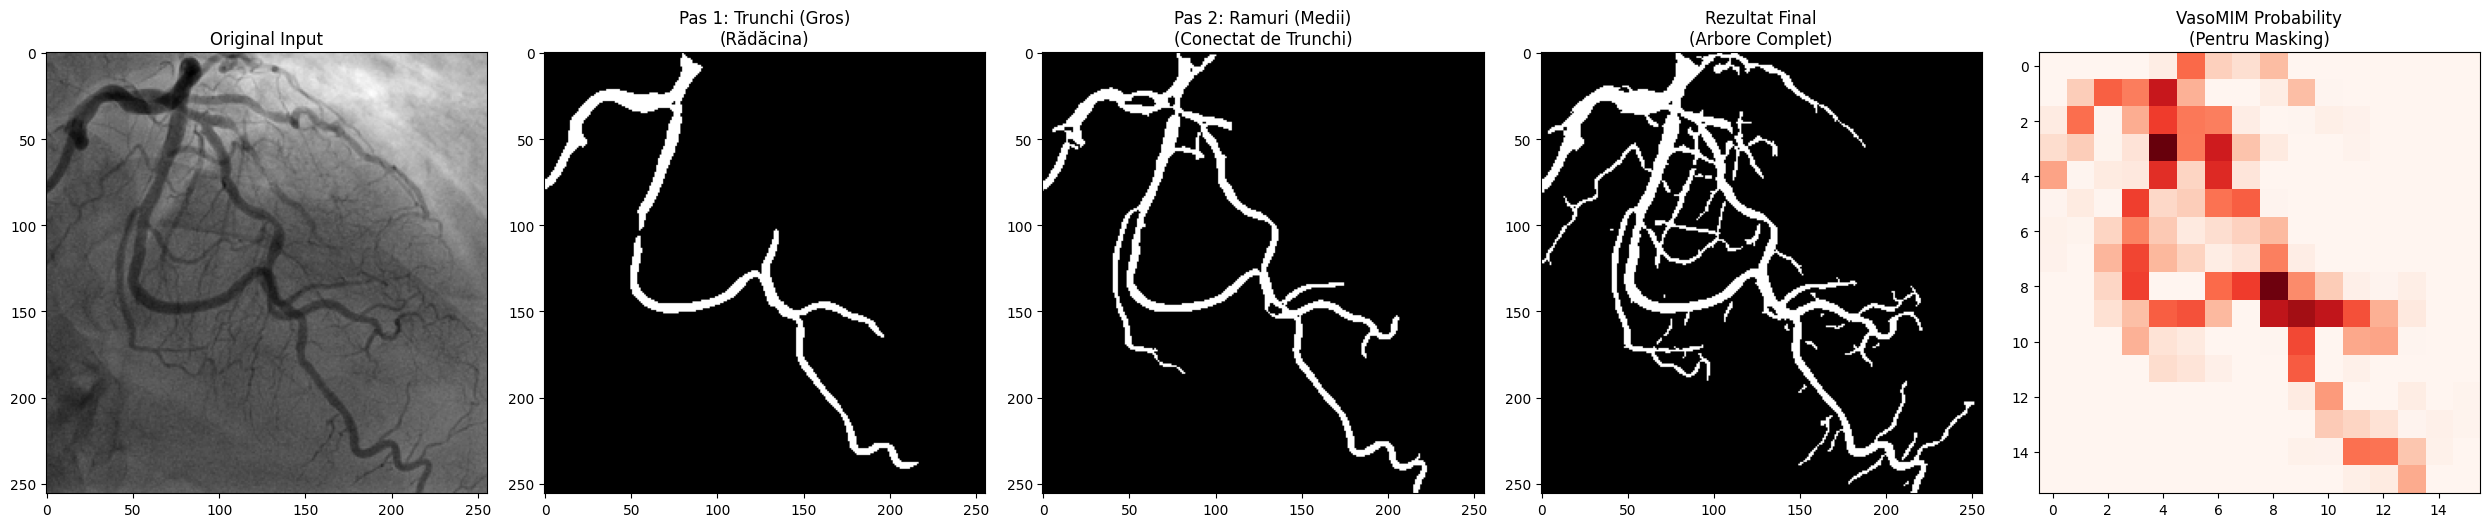

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from skimage.filters import frangi, gaussian, threshold_otsu
from skimage import exposure, morphology, measure
from skimage.measure import label, regionprops, block_reduce
from skimage.morphology import disk, reconstruction

import numpy as np
from skimage.filters import frangi, gaussian, threshold_otsu
from skimage import exposure, morphology
from skimage.measure import label, regionprops, block_reduce
from skimage.morphology import disk, reconstruction

def get_vasomim_probability_map(img):
    mask_roi = img > 0.05 
    mask_roi = morphology.binary_erosion(mask_roi, disk(15))
    
    img_clahe = exposure.equalize_adapthist(img, clip_limit=0.02, kernel_size=(32, 32))
    img_smooth = gaussian(img_clahe, sigma=1.0)

    scales_config = [
        {'sigma': 3.5, 'thresh_factor': 0.60}, 
        {'sigma': 2.0, 'thresh_factor': 0.45}  
    ]
    
    accumulated_mask = np.zeros_like(img, dtype=bool)
    accumulated_prob = np.zeros_like(img, dtype=float)

    for i, config in enumerate(scales_config):
        f_scale = frangi(img_smooth, sigmas=[config['sigma']], black_ridges=True, beta=0.5, gamma=2)
        f_scale = f_scale * mask_roi 
        
        if f_scale.max() > 0:
            f_scale = f_scale / f_scale.max()
            
        thresh = threshold_otsu(f_scale) if f_scale.max() > 0 else 0.1
        candidates = f_scale > (thresh * config['thresh_factor'])
        
        valid_layer = np.zeros_like(candidates)
        
        if i == 0:
            labels = label(candidates)
            if labels.max() > 0:
                regions = regionprops(labels)
                regions.sort(key=lambda x: x.area, reverse=True)
                
                largest = regions[0]
                valid_layer[labels == largest.label] = 1
                
                if len(regions) > 1 and regions[1].area > largest.area * 0.2:
                     valid_layer[labels == regions[1].label] = 1
        else:
            prev_dilated = morphology.binary_dilation(accumulated_mask, disk(4))
            seed = candidates & prev_dilated
            
            if seed.sum() > 0:
                valid_layer = reconstruction(seed, candidates, method='dilation').astype(bool)
                
        accumulated_mask = accumulated_mask | valid_layer.astype(bool)
        accumulated_prob = np.maximum(accumulated_prob, f_scale * valid_layer)

    PATCH_SIZE = 16
    
    final_prob_dilated = morphology.dilation(accumulated_prob, disk(2))
    patch_density = block_reduce(final_prob_dilated, block_size=(PATCH_SIZE, PATCH_SIZE), func=np.mean)
    
    h_p, w_p = patch_density.shape
    y, x = np.ogrid[:h_p, :w_p]
    center_bias = np.exp(-((x - w_p/2)**2 + (y - h_p/2)**2) / (2 * (w_p/2.5)**2))
    
    vasomim_probs = patch_density * center_bias
    vasomim_probs = (vasomim_probs - vasomim_probs.min()) / (vasomim_probs.max() - vasomim_probs.min() + 1e-6)
    vasomim_probs = vasomim_probs + 0.02 
    vasomim_probs = vasomim_probs / vasomim_probs.sum()

    return vasomim_probs.flatten()